### How to use this notebook
#### Imports
TODO: Write which packages the user has to import to use this notebook. Something like:
> pip install pandas matplotlib numpy seaborn basemap etc..

#### Data
In order to run this notebook you must first extract __birds.csv__ from __birds.zip__

In [28]:
# TODO: Cleanup imports that are not needed
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import itertools
import collections
import json
import nltk
from nltk.corpus import stopwords
from dwca.read import DwCAReader
from mpl_toolkits.basemap import Basemap
import re
pd.set_option("display.max_columns", None)
import datetime
import warnings
warnings.filterwarnings("ignore")
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [29]:
birds = pd.read_csv("birds.csv")
birds.head()

,vernacularName,verbatimScientificName,order,family,genus,specificEpithet,eventDate,year,month,day,stateProvince,locality,decimalLatitude,decimalLongitude,individualCount,iucnRedListCategory
0,Lesser Black-backed Gull,Larus fuscus,Charadriiformes,Laridae,Larus,fuscus,2016-05-31T00:00:00,2016,5,31,Suðurland,Heimaey--Víkin,63.408356,-20.280504,1.0,LC
1,Ruddy Turnstone,Arenaria interpres,Charadriiformes,Scolopacidae,Arenaria,interpres,2004-09-17T00:00:00,2004,9,17,Suðurnes,Garður,64.072426,-22.660074,NaN,LC
2,Glaucous Gull,Larus hyperboreus,Charadriiformes,Laridae,Larus,hyperboreus,2010-11-24T00:00:00,2010,11,24,Norðurland eystra,Húsavík--hafnarsvæði (harbour area),66.044800,-17.349987,NaN,LC
3,Eurasian Wigeon,Mareca penelope,Anseriformes,Anatidae,Anas,penelope,2018-06-24T00:00:00,2018,6,24,Suðurland,"(63.6731,-20.3561)",63.673130,-20.356092,2.0,LC
4,Mallard,Anas platyrhynchos,Anseriformes,Anatidae,Anas,platyrhynchos,2020-02-29T00:00:00,2020,2,29,Vestfirðir,Bolungarvik--hafnarsvaedi (harbour area),66.157510,-23.244152,11.0,LC


In [30]:
# Haförn
eagles = birds[birds["vernacularName"] == "White-tailed Eagle"]
eagles.head()

,vernacularName,verbatimScientificName,order,family,genus,specificEpithet,eventDate,year,month,day,stateProvince,locality,decimalLatitude,decimalLongitude,individualCount,iucnRedListCategory
1138,White-tailed Eagle,Haliaeetus albicilla,Accipitriformes,Accipitridae,Haliaeetus,albicilla,2017-09-09T00:00:00,2017,9,9,Höfuðborgarsvæði,Reykjavík--Örfirisey,64.158350,-21.942057,2.0,LC
1314,White-tailed Eagle,Haliaeetus albicilla,Accipitriformes,Accipitridae,Haliaeetus,albicilla,2012-02-25T00:00:00,2012,2,25,Vestfirðir,Dyrafjordur--Kjaransstaðareyri,65.847250,-23.297195,1.0,LC
1409,White-tailed Eagle,Haliaeetus albicilla,Accipitriformes,Accipitridae,Haliaeetus,albicilla,2018-05-31T00:00:00,2018,5,31,Vesturland,Borgarfjörður,64.547966,-21.844116,1.0,LC
9623,White-tailed Eagle,Haliaeetus albicilla,Accipitriformes,Accipitridae,Haliaeetus,albicilla,2018-07-14T00:00:00,2018,7,14,Vesturland,Stykkishólmur,65.078384,-22.724790,3.0,LC
11449,White-tailed Eagle,Haliaeetus albicilla,Accipitriformes,Accipitridae,Haliaeetus,albicilla,2016-06-14T00:00:00,2016,6,14,Vesturland,Borgarnes,64.540344,-21.917790,1.0,LC


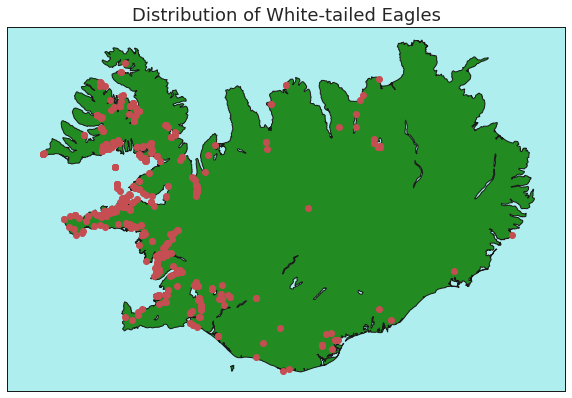

In [31]:
# Distribution of White-tailed Eagles

fig, ax = plt.subplots(figsize=(10,20))
# Map setup
m = Basemap(resolution = "h", # High resolution
        projection = "merc", # Mercator projection
        llcrnrlon = -25.33,
        llcrnrlat = 63.2,
        urcrnrlon = -12.8,
        urcrnrlat = 66.66
       )
land_color = "forestgreen"
ocean_color =  "paleturquoise"
m.drawcoastlines()
m.fillcontinents(color=land_color,lake_color=ocean_color)
m.drawmapboundary(fill_color=ocean_color)

# Helper function to plot birds
def plot_birds(b):
    lon = b["decimalLongitude"]
    lat = b["decimalLatitude"]
    x,y = m(lon, lat)
    m.plot(x, y, "ro") # ro = red dot

# Iterate over the dataframe and plot coordinates
for index, row in eagles.iterrows():
    plot_birds(row)

plt.title("Distribution of White-tailed Eagles")
plt.show()